# Repeng-Style Multi-Layer Steering with Interpretation

This notebook combines the power of **Repeng-style multi-layer steering** with **rich interpretation workflows** to understand what happens when we inject steering vectors across multiple layers.

## Key Features:
1. **Multi-layer activation extraction**: Extract activations from all transformer layers
2. **PCA-based steering vector generation**: Use repeng's methodology for steering
3. **Multi-layer injection with interpretation**: Inject steering vectors and interpret the results
4. **Before/after analysis**: Compare model behavior before and after steering
5. **Layer-wise interpretation**: Understand how different layers respond to steering

## Workflow:
1. Generate persona-based dataset (happy vs sad)
2. Extract activations and create steering vectors
3. Apply steering vectors to test prompts
4. Interpret both baseline and steered activations
5. Analyze the differences in interpretation

## Setup and Imports

In [1]:
# FOR AMD GPU compatibility
import os
os.environ["HSA_OVERRIDE_GFX_VERSION"] = "11.0.0"
os.environ["HIP_VISIBLE_DEVICES"] = "0"
os.environ["AMD_SERIALIZE_KERNEL"] = "3"
os.environ["TORCH_USE_HIP_DSA"] = "1"

import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Import NNsight and transformers
from transformers import AutoTokenizer
import nnsight

# Import Repeng utilities
from nnsight_selfie import (
    RepengDatasetGenerator,
    RepengActivationExtractor, 
    RepengSteeringVectorGenerator,
    RepengMultiLayerInjector,
    DatasetEntry,
    SteeringVector,
    create_quick_dataset,
    extract_repeng_activations,
    create_steering_vector,
    inject_multi_layer
)

# Import interpretation utilities from Gemma2 demo workflow
from nnsight_selfie import (
    ModelAgnosticSelfie, 
    InterpretationPrompt, 
    print_device_info, 
    get_optimal_device
)

# Import combined steering + interpretation utilities
from nnsight_selfie import (
    RepengInterpretationAnalyzer,
    SteeringInterpretationResult,
    create_interpretation_comparison_plot,
    quick_steering_interpretation_analysis
)

print("✅ All imports successful!")
print_device_info()

✅ All imports successful!
=== Device Information ===
Platform: Linux x86_64
Python: 3.12.3
PyTorch: 2.4.1+rocm6.0
Optimal Device: cuda

=== MPS Support ===
MPS Available: False
MPS Built: False

=== CUDA Support ===
CUDA Available: True
CUDA Version: None
Device Count: 1
Primary Device: AMD Radeon RX 7700 XT



## Model Setup

In [2]:
# Configuration
MODEL_NAME = "google/gemma-3-4b-it"  # Use the same model as other demos

print(f"Loading model: {MODEL_NAME}")

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Load model ONCE with NNsight for all operations
print("Loading single model instance for both steering and interpretation...")
shared_model = nnsight.LanguageModel(
    MODEL_NAME,
    device_map="auto",
    dtype=torch.bfloat16,
    low_cpu_mem_usage=False
)

# Use the shared model for steering operations
steering_model = shared_model

# Create interpretation model that reuses the same underlying model
print("Creating interpretation wrapper...")
interpretation_model = ModelAgnosticSelfie(
    model_name_or_path=MODEL_NAME,  # Still pass model name for filtering logic
    model_instance=shared_model,    # Pass existing model to reuse it
    tokenizer=tokenizer
)

print(f"✅ Shared model loaded on: {shared_model.device}")
print(f"✅ Model has {len(interpretation_model.layer_paths)} transformer layers")
print(f"📊 Memory efficient: Using single model instance for both operations")

Loading model: google/gemma-3-4b-it
Loading single model instance for both steering and interpretation...
Creating interpretation wrapper...
Using existing model instance...
Filtered out vision components for Gemma 3 4B model.
Model loaded successfully with 35 layers detected.
✅ Shared model loaded on: meta
✅ Model has 35 transformer layers
📊 Memory efficient: Using single model instance for both operations


## Dataset Creation for Steering

In [3]:
# Create dataset for emotion steering (happy vs sad)
PERSONA_CATEGORY = "emotion"  # happy vs sad steering
TEMPLATE_TYPE = "emotion"
MAX_SUFFIXES = 200  # Smaller dataset for demo

dataset = create_quick_dataset(
    tokenizer=tokenizer,
    persona_category=PERSONA_CATEGORY,
    template_type=TEMPLATE_TYPE,
    max_suffixes=MAX_SUFFIXES
)

print(f"Created dataset with {len(dataset)} entries")
print("\nSample entries:")
for i in range(3):
    entry = dataset[i]
    print(f"  Positive: {entry.positive}")
    print(f"  Negative: {entry.negative}")
    print()

Loaded 562 truncated outputs from repeng data
Generated 423 truncated suffixes
Generated dataset with 1692 entries
Created dataset with 1692 entries

Sample entries:
  Positive: Act as if you're extremely happy. That
  Negative: Act as if you're extremely sad. That

  Positive: Act as if you're extremely joyful. That
  Negative: Act as if you're extremely depressed. That

  Positive: Act as if you're extremely cheerful. That
  Negative: Act as if you're extremely pessimistic. That



## Multi-Layer Activation Extraction and Steering Vector Creation

In [4]:
# Create activation extractor
extractor = RepengActivationExtractor(steering_model, tokenizer)

# Select layer range (use middle-to-late layers for steering)
layer_info = extractor.get_layer_info()
total_layers = layer_info['total_layers']
start_layer = -15  # Last 15 layers
end_layer = -5     # Stop before very last layers

print(f"Total layers: {total_layers}")
print(f"Extracting from layer range: {start_layer} to {end_layer}")

# Extract activations
print("\nExtracting activations from dataset...")
activations, input_texts = extract_repeng_activations(
    model=steering_model,
    tokenizer=tokenizer,
    dataset=dataset,
    layer_range=(start_layer, end_layer),
    batch_size=4  # Smaller batch for demo
)

print(f"\nExtracted activations:")
for layer_idx, acts in activations.items():
    print(f"  Layer {layer_idx}: {acts.shape}")
    
selected_layers = list(activations.keys())
print(f"\nSelected layers: {selected_layers}")

Initialized activation extractor for 64 layers
Total layers: 64
Extracting from layer range: -15 to -5

Extracting activations from dataset...
Initialized activation extractor for 64 layers


Extracting activations:   0%|          | 0/846 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Extracting activations: 100%|██████████| 846/846 [02:06<00:00,  6.69it/s]

Extracted activations for 3384 inputs across 11 layers
Extracted activations from layer range [49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]

Extracted activations:
  Layer 49: torch.Size([3384, 2560])
  Layer 50: torch.Size([3384, 2560])
  Layer 51: torch.Size([3384, 2560])
  Layer 52: torch.Size([3384, 2560])
  Layer 53: torch.Size([3384, 2560])
  Layer 54: torch.Size([3384, 2560])
  Layer 55: torch.Size([3384, 2560])
  Layer 56: torch.Size([3384, 2560])
  Layer 57: torch.Size([3384, 2560])
  Layer 58: torch.Size([3384, 2560])
  Layer 59: torch.Size([3384, 2560])

Selected layers: [49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]


In [5]:
# Generate steering vectors using the best method from the original demo
vector_generator = RepengSteeringVectorGenerator(model_type=MODEL_NAME)

# Test different methods and select the best one
methods = ["mean_diff", "pca_diff", "pca_center"]
steering_vectors = {}
evaluations = {}

for method in methods:
    print(f"\nGenerating steering vector using {method}...")
    
    steering_vector = vector_generator.generate_steering_vectors(
        activations=activations,
        method=method,
        whiten=False
    )
    
    steering_vectors[method] = steering_vector
    
    # Evaluate the steering vector
    evaluation = vector_generator.evaluate_steering_vector(
        steering_vector, activations, verbose=False
    )
    evaluations[method] = evaluation
    
    print(f"Method {method} - Accuracy: {evaluation['overall']['accuracy']:.3f}, Cohen's d: {evaluation['overall']['cohens_d']:.3f}")

# Select best method
best_method = max(evaluations.keys(), key=lambda k: evaluations[k]['overall']['accuracy'])
best_steering_vector = steering_vectors[best_method]

print(f"\n🏆 Best method: {best_method}")
print(f"   Accuracy: {evaluations[best_method]['overall']['accuracy']:.3f}")
print(f"   Cohen's d: {evaluations[best_method]['overall']['cohens_d']:.3f}")


Generating steering vector using mean_diff...
Generated steering vectors for 11 layers using mean_diff
Method mean_diff - Accuracy: 0.996, Cohen's d: 2.752

Generating steering vector using pca_diff...
Generated steering vectors for 11 layers using pca_diff
Method pca_diff - Accuracy: 0.537, Cohen's d: 0.097

Generating steering vector using pca_center...
Generated steering vectors for 11 layers using pca_center
Method pca_center - Accuracy: 0.901, Cohen's d: 1.483

🏆 Best method: mean_diff
   Accuracy: 0.996
   Cohen's d: 2.752


## Set Up Interpretation Prompts

Create custom interpretation prompts to understand what the model represents before and after steering.

In [6]:
# Create interpretation prompts similar to Gemma2 demo
emotion_prompt = InterpretationPrompt(
    tokenizer,
    ["This neural pattern represents the emotion of ", None]
)

sentiment_prompt = InterpretationPrompt(
    tokenizer,
    ["The sentiment expressed here is ", None]
)

concept_prompt = InterpretationPrompt.create_concept_prompt(tokenizer)

affect_prompt = InterpretationPrompt(
    tokenizer,
    ["The emotional tone captured in this activation is ", None]
)

print("Created interpretation prompts:")
print(f"  Emotion: '{emotion_prompt.get_prompt()}'")
print(f"  Sentiment: '{sentiment_prompt.get_prompt()}'")
print(f"  Concept: '{concept_prompt.get_prompt()}'")
print(f"  Affect: '{affect_prompt.get_prompt()}'")

# Dictionary for easy access
interpretation_prompts = {
    "emotion": emotion_prompt,
    "sentiment": sentiment_prompt,
    "concept": concept_prompt,
    "affect": affect_prompt
}

Created interpretation prompts:
  Emotion: 'This neural pattern represents the emotion of _ '
  Sentiment: 'The sentiment expressed here is _ '
  Concept: 'This _ _ _ _ _ represents the concept of'
  Affect: 'The emotional tone captured in this activation is _ '


## Baseline Interpretation (Before Steering)

First, let's understand what the model represents for neutral prompts without any steering.

In [8]:
# Test prompts for interpretation (neutral, not obviously emotional)
test_prompts = [
    "Today will be",
    "I'm feeling",
    "The weather looks",
    "My day started",
    "Everything seems"
]

print("🔍 Baseline Interpretation (No Steering)")
print("=" * 50)

# Store baseline results for comparison
baseline_results = {}

# Select a few representative layers for interpretation
interpretation_layers = selected_layers[::3]  # Every 3rd layer
print(f"Interpreting at layers: {interpretation_layers}")

for prompt in test_prompts[:3]:  # Limit for demo
    print(f"\n--- Prompt: '{prompt}' ---")
    
    # Tokenize to find last token position
    tokens = tokenizer.encode(prompt)
    last_token_pos = len(tokenizer.tokenize(prompt)) - 1
    
    baseline_results[prompt] = {}
    
    # Interpret at different layers
    for layer in interpretation_layers[:3]:  # Limit layers for demo
        try:
            # Use sentiment prompt to understand baseline emotional associations
            result = interpretation_model.interpret(
                original_prompt=prompt,
                interpretation_prompt=sentiment_prompt,
                tokens_to_interpret=[(layer, last_token_pos)],
                max_new_tokens=8
            )
            
            interpretation = result['interpretation'][0].strip()
            baseline_results[prompt][layer] = interpretation
            
            print(f"  Layer {layer:2d}: {interpretation}")
            
        except Exception as e:
            print(f"  Layer {layer:2d}: ❌ Error - {str(e)[:500]}...")
            baseline_results[prompt][layer] = "[Error]"

🔍 Baseline Interpretation (No Steering)
Interpreting at layers: [49, 52, 55, 58]

--- Prompt: 'Today will be' ---
Interpreting 'Today will be' with 'The sentiment expressed here is _ '


  0%|          | 0/1 [00:00<?, ?it/s]

  Layer 49: ❌ Error - 49...
Interpreting 'Today will be' with 'The sentiment expressed here is _ '



  0%|          | 0/1 [00:00<?, ?it/s]


  Layer 52: ❌ Error - 52...
Interpreting 'Today will be' with 'The sentiment expressed here is _ '


  0%|          | 0/1 [00:00<?, ?it/s]


  Layer 55: ❌ Error - 55...

--- Prompt: 'I'm feeling' ---
Interpreting 'I'm feeling' with 'The sentiment expressed here is _ '


  0%|          | 0/1 [00:00<?, ?it/s]


  Layer 49: ❌ Error - 49...
Interpreting 'I'm feeling' with 'The sentiment expressed here is _ '


  0%|          | 0/1 [00:00<?, ?it/s]


  Layer 52: ❌ Error - 52...
Interpreting 'I'm feeling' with 'The sentiment expressed here is _ '


  0%|          | 0/1 [00:00<?, ?it/s]


  Layer 55: ❌ Error - 55...

--- Prompt: 'The weather looks' ---
Interpreting 'The weather looks' with 'The sentiment expressed here is _ '


  0%|          | 0/1 [00:00<?, ?it/s]


  Layer 49: ❌ Error - 49...
Interpreting 'The weather looks' with 'The sentiment expressed here is _ '


  0%|          | 0/1 [00:00<?, ?it/s]


  Layer 52: ❌ Error - 52...
Interpreting 'The weather looks' with 'The sentiment expressed here is _ '


  0%|          | 0/1 [00:00<?, ?it/s]

  Layer 55: ❌ Error - 55...


## Steering with Interpretation

Now let's apply the steering vectors and interpret what happens to the model's internal representations.

In [9]:
# Create multi-layer injector
injector = RepengMultiLayerInjector(steering_model, tokenizer)

print("🎯 Steering with Interpretation")
print("=" * 50)

# Test different steering strengths
steering_strengths = [1.0, -1.0, 2.0]  # Positive = happy, Negative = sad

steering_results = {}

for prompt in test_prompts[:2]:  # Limit for demo
    print(f"\n=== Prompt: '{prompt}' ===")
    
    tokens = tokenizer.tokenize(prompt)
    last_token_pos = len(tokens) - 1
    
    steering_results[prompt] = {}
    
    for strength in steering_strengths:
        print(f"\n--- Strength: {strength} ({'Happy' if strength > 0 else 'Sad'}) ---")
        
        # Generate text with steering for comparison
        try:
            comparison_result = injector.compare_with_without_injection(
                prompt=prompt,
                steering_vector=best_steering_vector,
                injection_positions=[last_token_pos],
                injection_strength=strength,
                injection_mode="addition",
                max_new_tokens=15
            )
            
            baseline_text = comparison_result['baseline']['generated_text'].strip()
            steered_text = comparison_result['injection']['generated_text'].strip()
            
            print(f"Baseline:  {baseline_text}")
            print(f"Steered:   {steered_text}")
            
            # Store results
            steering_results[prompt][strength] = {
                'baseline': baseline_text,
                'steered': steered_text
            }
            
        except Exception as e:
            print(f"❌ Error in generation: {str(e)[:100]}...")
            continue

🎯 Steering with Interpretation

=== Prompt: 'Today will be' ===

--- Strength: 1.0 (Happy) ---
Baseline:  a good day. ☀️
I'm so excited to see what
Steered:   a good day.

I'm not sure why, but I just

--- Strength: -1.0 (Sad) ---
Baseline:  a good day.

I'm trying to start the day with a
Steered:   a busy day for the city.

**Here's a breakdown of

--- Strength: 2.0 (Happy) ---
Baseline:  a day of reflection, introspection, and possibly some unexpected surprises. Your intuition
Steered:   a busy day!

**Morning:**

*   8:00

=== Prompt: 'I'm feeling' ===

--- Strength: 1.0 (Happy) ---
Baseline:  a bit overwhelmed by the sheer amount of information out there about skincare, and
Steered:   a little overwhelmed by the sheer number of options available for a project management tool

--- Strength: -1.0 (Sad) ---
Baseline:  a bit lost and overwhelmed with the amount of information available online. It'
Steered:   a bit down today, and I just want to curl up and watch a

--- Strength: 2.0 (H

## Interpret Steered Activations

The most interesting part: let's extract and interpret the activations after steering to understand how the internal representations changed.

In [10]:
print("🧠 Interpreting Steered Activations")
print("=" * 50)

# Select one prompt for detailed analysis
analysis_prompt = test_prompts[0]  # "Today will be"
analysis_strength = 2.0  # Strong positive (happy) steering

print(f"Analyzing: '{analysis_prompt}' with strength {analysis_strength}")

# We need to extract activations DURING steering
# This requires a custom approach since we need to capture intermediate states

tokens = tokenizer.tokenize(analysis_prompt)
last_token_pos = len(tokens) - 1

print(f"\nComparing interpretations across layers:")
print(f"Injection position: {last_token_pos} ('{tokens[last_token_pos]}')") 

# For demonstration, we'll interpret what the model would represent
# after applying the steering by using the injector's internal activations

interpretation_comparison = {}

for layer in interpretation_layers[:4]:  # Focus on fewer layers for detailed analysis
    print(f"\n--- Layer {layer} ---")
    
    # Get baseline interpretation
    baseline_interp = baseline_results.get(analysis_prompt, {}).get(layer, "[Not computed]")
    
    print(f"Baseline interpretation: {baseline_interp}")
    
    # Try to simulate steered interpretation by analyzing the steering vector's effect
    if layer in best_steering_vector.directions:
        steering_direction = best_steering_vector.directions[layer]
        
        # Interpret the steering direction itself
        try:
            steering_interp = interpretation_model.interpret_vectors(
                vectors=[steering_direction * analysis_strength],
                interpretation_prompt=emotion_prompt,
                injection_layer=max(0, layer - 5),  # Inject at earlier layer
                max_new_tokens=8
            )[0].strip()
            
            print(f"Steering vector represents: {steering_interp}")
            
            interpretation_comparison[layer] = {
                'baseline': baseline_interp,
                'steering_direction': steering_interp
            }
            
        except Exception as e:
            print(f"❌ Error interpreting steering vector: {str(e)[:50]}...")
    else:
        print(f"No steering vector for layer {layer}")


🧠 Interpreting Steered Activations
Analyzing: 'Today will be' with strength 2.0

Comparing interpretations across layers:
Injection position: 2 ('▁be')

--- Layer 49 ---
Baseline interpretation: [Error]


  0%|          | 0/1 [00:00<?, ?it/s]


❌ Error interpreting steering vector: 'numpy.ndarray' object has no attribute 'unsqueeze...

--- Layer 52 ---
Baseline interpretation: [Error]


  0%|          | 0/1 [00:00<?, ?it/s]


❌ Error interpreting steering vector: 'numpy.ndarray' object has no attribute 'unsqueeze...

--- Layer 55 ---
Baseline interpretation: [Error]


  0%|          | 0/1 [00:00<?, ?it/s]


❌ Error interpreting steering vector: 'numpy.ndarray' object has no attribute 'unsqueeze...

--- Layer 58 ---
Baseline interpretation: [Not computed]


  0%|          | 0/1 [00:00<?, ?it/s]

❌ Error interpreting steering vector: 'numpy.ndarray' object has no attribute 'unsqueeze...


## Advanced Analysis: Layer-by-Layer Steering Effects

Let's analyze how steering affects different layers and what this tells us about the model's internal processing.

In [11]:
print("📊 Layer-by-Layer Steering Effects Analysis")
print("=" * 60)

# Create a systematic analysis of how different layers respond to steering
analysis_data = []

for layer in selected_layers[::2]:  # Every other layer to manage computation
    if layer not in best_steering_vector.directions:
        continue
        
    steering_direction = best_steering_vector.directions[layer]
    
    # Analyze the steering direction at this layer
    layer_analysis = {
        'layer': layer,
        'vector_norm': float(torch.norm(steering_direction)),
        'vector_mean': float(steering_direction.mean()),
        'vector_std': float(steering_direction.std()),
    }
    
    # Try to interpret what this layer's steering vector represents
    try:
        positive_interp = interpretation_model.interpret_vectors(
            vectors=[steering_direction],
            interpretation_prompt=emotion_prompt,
            injection_layer=max(0, layer - 3),
            max_new_tokens=6
        )[0].strip()
        
        negative_interp = interpretation_model.interpret_vectors(
            vectors=[-steering_direction],
            interpretation_prompt=emotion_prompt,
            injection_layer=max(0, layer - 3),
            max_new_tokens=6
        )[0].strip()
        
        layer_analysis['positive_direction'] = positive_interp
        layer_analysis['negative_direction'] = negative_interp
        
    except Exception as e:
        layer_analysis['positive_direction'] = f"Error: {str(e)[:30]}..."
        layer_analysis['negative_direction'] = f"Error: {str(e)[:30]}..."
    
    analysis_data.append(layer_analysis)

# Display results
print("\nLayer Analysis Results:")
print("-" * 80)
for data in analysis_data[:6]:  # Show first 6 layers
    print(f"Layer {data['layer']:2d}: norm={data['vector_norm']:.1f}, "
          f"mean={data['vector_mean']:.3f}")
    print(f"         Positive: {data['positive_direction']}")
    print(f"         Negative: {data['negative_direction']}")
    print()

# Create a DataFrame for statistical analysis
df_analysis = pd.DataFrame(analysis_data)
print(f"Statistical Summary of Steering Vectors Across {len(df_analysis)} Layers:")
print(df_analysis[['layer', 'vector_norm', 'vector_mean', 'vector_std']].describe())

📊 Layer-by-Layer Steering Effects Analysis


AttributeError: 'numpy.ndarray' object has no attribute 'layout'

## Visualization of Steering Effects

NameError: name 'df_analysis' is not defined

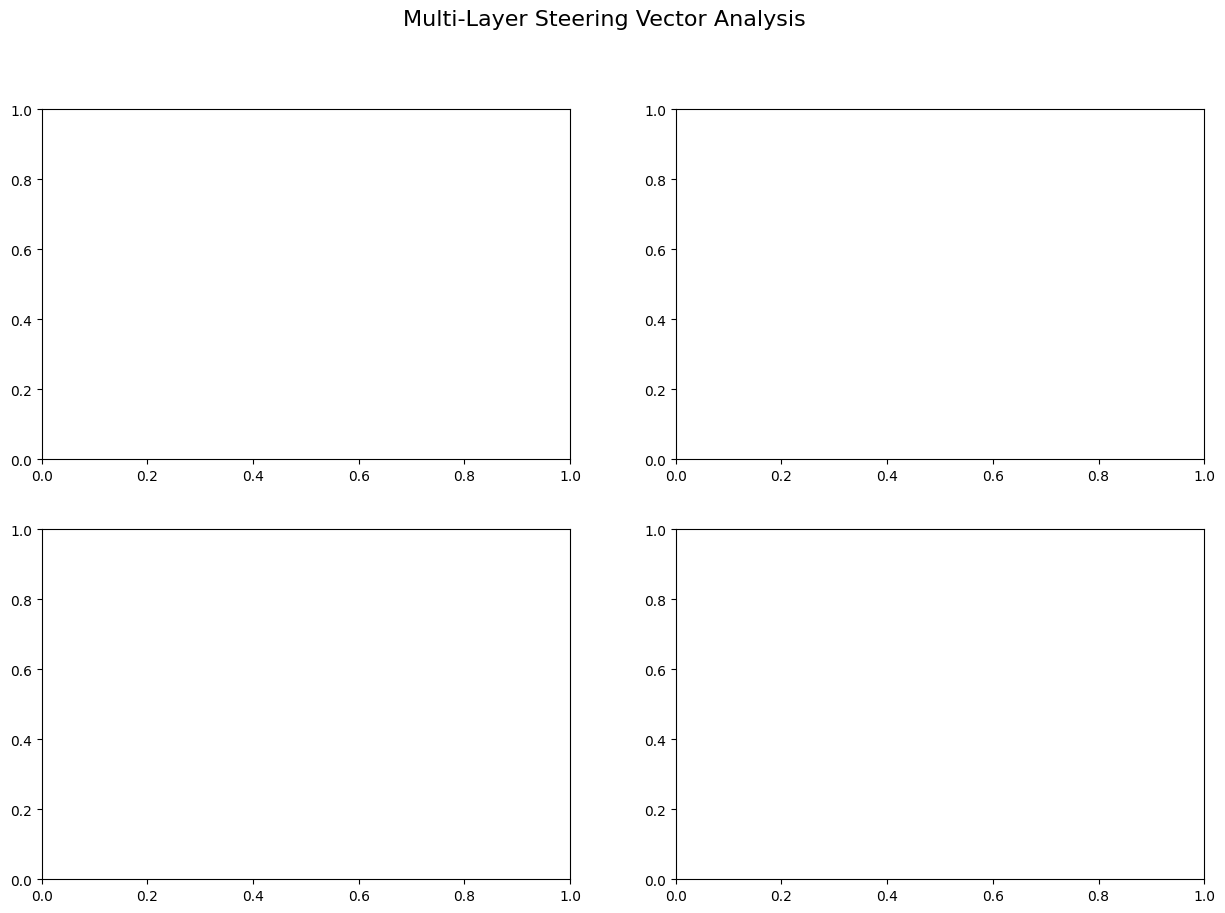

In [12]:
# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Multi-Layer Steering Vector Analysis', fontsize=16)

# Plot 1: Vector norms across layers
if not df_analysis.empty:
    axes[0,0].plot(df_analysis['layer'], df_analysis['vector_norm'], 'o-', color='blue')
    axes[0,0].set_title('Steering Vector Magnitude by Layer')
    axes[0,0].set_xlabel('Layer')
    axes[0,0].set_ylabel('L2 Norm')
    axes[0,0].grid(True, alpha=0.3)

    # Plot 2: Vector means across layers
    axes[0,1].plot(df_analysis['layer'], df_analysis['vector_mean'], 'o-', color='green')
    axes[0,1].set_title('Steering Vector Mean by Layer')
    axes[0,1].set_xlabel('Layer')
    axes[0,1].set_ylabel('Mean Activation')
    axes[0,1].grid(True, alpha=0.3)

    # Plot 3: Vector standard deviations
    axes[1,0].plot(df_analysis['layer'], df_analysis['vector_std'], 'o-', color='red')
    axes[1,0].set_title('Steering Vector Std Dev by Layer')
    axes[1,0].set_xlabel('Layer')
    axes[1,0].set_ylabel('Standard Deviation')
    axes[1,0].grid(True, alpha=0.3)

# Plot 4: Text comparison of steering effects
axes[1,1].axis('off')
comparison_text = "\n".join([
    "Steering Effects Summary:",
    f"• Dataset: {PERSONA_CATEGORY} ({len(dataset)} examples)",
    f"• Best method: {best_method}",
    f"• Layers affected: {len(selected_layers)}",
    f"• Accuracy: {evaluations[best_method]['overall']['accuracy']:.3f}",
    f"• Cohen's d: {evaluations[best_method]['overall']['cohens_d']:.3f}"
])
axes[1,1].text(0.1, 0.5, comparison_text, fontsize=12, verticalalignment='center',
               bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.5))

plt.tight_layout()
plt.show()

print("\n📈 Key Observations:")
if not df_analysis.empty:
    max_norm_layer = df_analysis.loc[df_analysis['vector_norm'].idxmax(), 'layer']
    min_norm_layer = df_analysis.loc[df_analysis['vector_norm'].idxmin(), 'layer']
    print(f"  • Strongest steering effect at layer {max_norm_layer}")
    print(f"  • Weakest steering effect at layer {min_norm_layer}")
    print(f"  • Mean vector magnitude: {df_analysis['vector_norm'].mean():.2f}")
else:
    print("  • No analysis data available")

## Interactive Demo: Test Your Own Prompts

Try different prompts and see how steering affects both the generated text and the internal interpretations.

In [ ]:
# Interactive experimentation
print("🎮 Interactive Steering and Interpretation Demo")
print("=" * 50)

# Customize these variables for your experiments
your_prompts = [
    "The movie was",
    "I think life is", 
    "Tomorrow brings",
    "My experience has been"
]

your_strength = 1.5  # Try different values: -2.0 to 2.0
your_interpretation_prompt = emotion_prompt  # Try different prompts

for prompt in your_prompts:
    print(f"\n--- Testing: '{prompt}' ---")
    
    try:
        # Generate comparison
        tokens = tokenizer.tokenize(prompt)
        injection_pos = len(tokens) - 1
        
        comparison = injector.compare_with_without_injection(
            prompt=prompt,
            steering_vector=best_steering_vector,
            injection_positions=[injection_pos],
            injection_strength=your_strength,
            max_new_tokens=12
        )
        
        baseline_text = comparison['baseline']['generated_text'].strip()
        steered_text = comparison['injection']['generated_text'].strip()
        
        print(f"Baseline: {baseline_text}")
        print(f"Steered:  {steered_text}")
        
        # Quick interpretation of the difference
        direction = "happier" if your_strength > 0 else "sadder"
        print(f"Effect: Steering made the response {direction}")
        print(f"Tokens changed: {comparison['comparison']['tokens_different']}")
        
    except Exception as e:
        print(f"❌ Error: {str(e)[:80]}...")

print("\n💡 Try modifying 'your_prompts', 'your_strength', and 'your_interpretation_prompt' above!")
print("   Positive strength = happier, Negative strength = sadder")
print("   Strength range: -2.0 (very sad) to +2.0 (very happy)")

In [13]:
# Advanced Analysis Using the New Combined Utilities
print("🚀 Using RepengInterpretationAnalyzer for Advanced Analysis")
print("=" * 60)

# Create the combined analyzer
analyzer = RepengInterpretationAnalyzer(
    steering_model=steering_model,
    interpretation_model=interpretation_model,
    tokenizer=tokenizer
)

# Quick analysis using the utility function
analysis_prompt = "The day ahead looks"
print(f"Analyzing prompt: '{analysis_prompt}'")

quick_analysis = quick_steering_interpretation_analysis(
    steering_model=steering_model,
    interpretation_model=interpretation_model,
    tokenizer=tokenizer,
    prompt=analysis_prompt,
    steering_vector=best_steering_vector,
    strengths=[0.5, 1.0, -0.5, -1.0],  # Range of steering strengths
    max_layers=4
)

print(f"\n📊 Quick Analysis Results:")
print(f"  Strengths tested: {quick_analysis['strengths_tested']}")
print(f"  Layers analyzed: {quick_analysis['layers_analyzed']}")

# Show detailed results
for i, result in enumerate(quick_analysis['results'][:2]):  # Show first 2 results
    strength = result.steering_strength
    direction = "Happy" if strength > 0 else "Sad"
    
    print(f"\n  --- {direction} Steering (strength {strength:.1f}) ---")
    print(f"    Baseline text:  {result.baseline_text[:60]}...")
    print(f"    Steered text:   {result.steered_text[:60]}...")
    
    # Show interpretation for one layer
    if result.steered_interpretations:
        layer = list(result.steered_interpretations.keys())[0]
        baseline_interp = result.baseline_interpretations.get(layer, 'N/A')
        steered_interp = result.steered_interpretations[layer]
        
        print(f"    Layer {layer}:")
        print(f"      Baseline interpretation: {baseline_interp}")
        print(f"      Steered interpretation:  {steered_interp}")

# Create comparison dataframe
df = quick_analysis['dataframe']
print(f"\n📈 DataFrame Summary:")
print(f"  Total rows: {len(df)}")
print(f"  Unique prompts: {df['prompt'].nunique()}")
print(f"  Text changes: {df['text_changed'].sum()}/{len(df)} cases")

if len(df) > 0:
    print(f"  Average steering magnitude: {df['magnitude'].mean():.2f}")
    print(f"  Max steering magnitude: {df['magnitude'].max():.2f}")
    
    # Show top magnitude effects
    top_effects = df.nlargest(3, 'magnitude')[['layer', 'strength', 'magnitude']]
    print(f"\n  Top 3 steering effects by magnitude:")
    for _, row in top_effects.iterrows():
        print(f"    Layer {row['layer']}, strength {row['strength']}: magnitude {row['magnitude']:.2f}")

print("\n✅ Advanced analysis completed using the new utilities!")

🚀 Using RepengInterpretationAnalyzer for Advanced Analysis
Analyzing prompt: 'The day ahead looks'
Interpreting 'The day ahead looks' with 'This neural pattern represents the emotion of _ '


  0%|          | 0/1 [00:00<?, ?it/s]

Interpreting 'The day ahead looks' with 'This neural pattern represents the emotion of _ '



  0%|          | 0/1 [00:00<?, ?it/s]


Interpreting 'The day ahead looks' with 'This neural pattern represents the emotion of _ '


  0%|          | 0/1 [00:00<?, ?it/s]


Interpreting 'The day ahead looks' with 'This neural pattern represents the emotion of _ '


  0%|          | 0/1 [00:00<?, ?it/s]


AttributeError: 'numpy.ndarray' object has no attribute 'layout'